In [1]:
import csv
from collections import defaultdict
import pandas as pd
import numpy as np
import sqlite3 as sql
import time
import requests
import json
import logging
from random import randint
import seaborn as sns
import scipy.stats as stats

DB_NAME = 'main.db'


NEW_BUILD = {"N": 0,
             "Y": 1}

HOUSE_TYPE ={"D":1,
             "S":2,
             "O":9,
             "T":3,
             "F":4}

CRIME_SCORE = { "bicycle-theft":4,
                "burglary":10,
               "criminal-damage-arson":9,
               "drugs":6,
               "other-theft":8,
               "possession-of-weapons:":10,
               "robbery":10,
               "shoplifting":4,
               "theft-from-the-person" :7,
               "vehicle-crime" : 10,
               "violent-crime": 10               
              }

sql_houses_leicestershire = """ CREATE TABLE IF NOT EXISTS leicestershire_houses (
                                id INTEGER PRIMARY KEY AUTOINCREMENT,
                                postcode text,
                                admin_district,
                                price int,
                                type int,
                                new_build int,
                                crime_score int,
                                broadband_speed int
                                ); """
sql_houses_warwickshire = """ CREATE TABLE IF NOT EXISTS warwickshire_houses (
                                id INTEGER PRIMARY KEY AUTOINCREMENT,
                                postcode text,
                                admin_district text
                                price int,
                                type int,
                                new_build int,
                                crime_score int,
                                broadband_speed int
                                ); """
leicestershire_houses = pd.read_csv('leicestershire_month_april_houses.csv')
broadband_performance = pd.read_csv('broadband_speed.csv')

In [2]:
def create_connection(db_file):
    conn = None
    try:
        conn = sql.connect(db_file)
        return conn
    except Error as e:
        print("dunno", e)

    return conn

In [3]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [4]:
def get_postcode_info_api(postcode):
    try: 
        api_string_req = 'http://127.0.0.1:8000/postcodes/{code}'.format(code = postcode)
        r = requests.get(api_string_req).json()
        return r['result']
    except Exception as e:
        print(e)
        return None


In [5]:
def create_sql_tables():
    conn = create_connection(DB_NAME)
    if conn is not None:
        create_table(conn, sql_houses_warwickshire)
        create_table(conn, sql_houses_leicestershire)
    else:
        print("Error! cannot create the database connection.")

In [6]:
def get_crime_external_api(lat,long):
    crime_score = 0
    for month in range(1,13):
        api_string_req = 'https://data.police.uk/api/crimes-at-location?date=2018-{month}&lat={lat}&lng={long}'.format(lat=lat,long=long, month= month)
        try:
            r = requests.get(api_string_req).json()
            for crime_data in r:
                try:
                    category = crime_data['category']
                    crime_score += CRIME_SCORE[category]
                except KeyError:
                    continue
        except Exception as e:
            print(e)
            continue
    return crime_score

In [7]:
def get_df_z_score(main_df):
    z_score_df = main_df[['price', 'crime_score', 'broadband_speed']].copy()
    return stats.zscore(z_score_df)

In [8]:
def database_populate(sql_connection,table,csv_houses):
    command = input("Heavy work ahead. hit Enter to continue...")
    cur = sql_connection.cursor()
    for index,data in csv_houses.iterrows():
        house_postcode = data['postcode']
        house_price = data['price_paid']
        additional_data = get_postcode_info_api(house_postcode)
        if additional_data is None:
            continue
        town_city = additional_data['admin_district']
        new_build = NEW_BUILD[data['new_build']]
        house_type = HOUSE_TYPE[data['property_type']]
        lsoa = additional_data['lsoa']
        admin_ward = additional_data['codes']['admin_ward']
        
        longitude = additional_data['longitude']
        latitude = additional_data['latitude']
        criminality_score = get_crime_external_api(latitude,longitude)
        for index,data in broadband_performance.iterrows():
            if data['id'] == admin_ward:
                    broadband_speed = data['average']
                    break
        
        sql_statement = """ INSERT INTO {table_name} 
        (postcode,admin_district,price,type,new_build,crime_score,broadband_speed) 
        VALUES ({pc}, {a}, {p}, {t}, {nb}, {cs}, {ba})""".format(
            table_name = table, 
            a = '"{}"'.format(town_city), 
            pc = '"{}"'.format(house_postcode), 
            p = house_price, 
            t = house_type, 
            nb = new_build,
            cs = criminality_score,
            ba = broadband_speed
        )
        cur.execute(sql_statement)

In [82]:
def basic_recommandation_system(database_connection):
    pd.set_option("display.precision", 15)
    pd.set_option('display.float_format', '{:.5f}'.format)

    print("Select a level of importance from 1-10 for the following")
    crime_rate = int(input("Crime Rate:"))
    price = int(input("House Price:"))
    broadband = int(input("Broadband Speed:"))
    added_up = sum([crime_rate,price,broadband])
    user_crime_score = crime_rate / added_up
    user_price_score = price / added_up
    user_broadband_score = broadband / added_up
    df = pd.read_sql_query("SELECT * from leicestershire_houses", database_connection)
    df["final_score"] = np.nan
    z_score = get_df_z_score(df)
    for index,data in df.iterrows():
        df.at[index,'final_score'] = z_score[index][0] * user_price_score +  z_score[index][1] * user_crime_score + (z_score[index][2] * -1) * user_broadband_score
    results = df.sort_values('final_score', ascending=True, kind="quicksort")
    print("There are the top 10 houses sold which fit your criteria best")
    print(results.head(10))

    best_locations = {}

    #check which location comes up the most out of the top 10 locations
    max_top = 10
    j = 0
    for index,data in results.iterrows():
        j+=1
        location = data["admin_district"]
        if location in best_locations:
            best_locations[location] +=1
        else:
            best_locations[location] = 1
        if j == max_top:
            break
    print()
    print("Best locations based on your criteria are:")
    for key in best_locations:
        print(key)

In [10]:
def get_required_data():
    with sql.connect(DB_NAME) as con:
        database_populate(con,"leicestershire_houses",leicestershire_houses)

In [11]:
# get_required_data(): # This is intensive don't run. data is already provided

In [12]:
con = create_connection(DB_NAME)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df = pd.read_sql_query("SELECT * from leicestershire_houses", con)
df.describe()

,id,price,type,new_build,crime_score,broadband_speed
count,971,971,971,971,971,971
mean,486,240690,2,0,46,49
std,280,118237,1,0,57,15
min,1,60000,1,0,0,18
25%,244,168000,1,0,10,31
50%,486,211000,2,0,28,54
75%,728,289998,3,0,62,62
max,971,1375000,4,1,375,78


<AxesSubplot:>

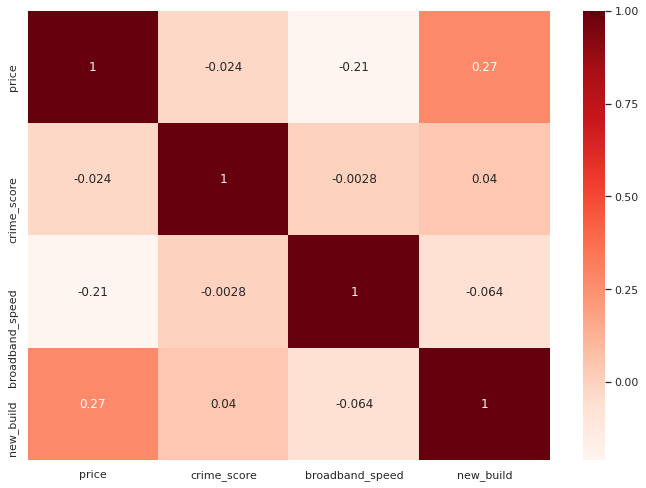

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df[['price','crime_score','broadband_speed','new_build']].corr(), annot=True, cmap = 'Reds')

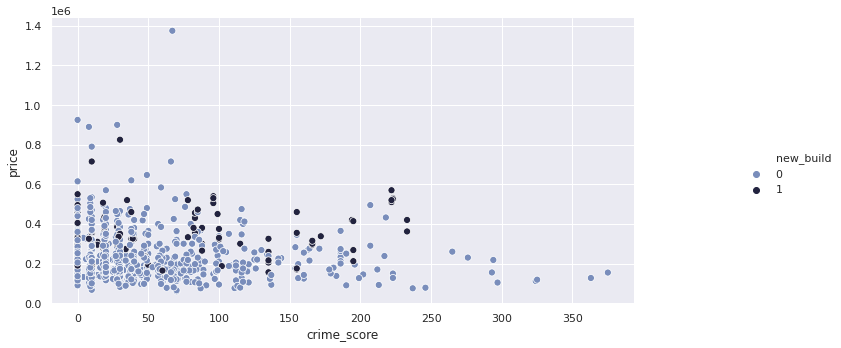

In [14]:
price = df['price']
g = sns.relplot(x="crime_score", y="price", hue="new_build", palette="ch:r=-.1,l=.55", data=df,s=50);
g.fig.set_size_inches(13,5)


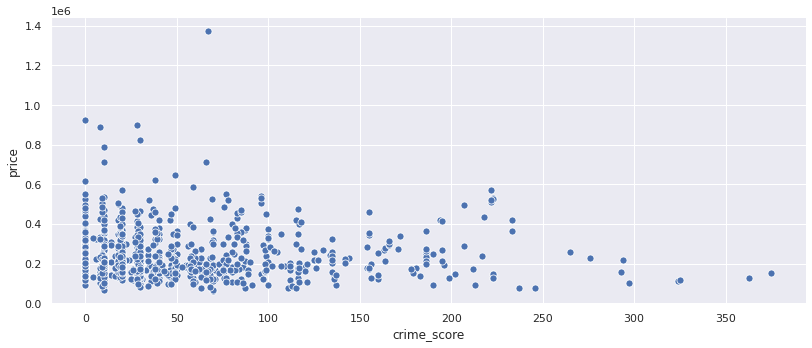

In [15]:
price = df['price']
g = sns.relplot(x="crime_score", y="price", palette="ch:r=-.25,l=.85", data=df,s=50);
g.fig.set_size_inches(13,5)


In [16]:
# get_required_data()  # Data is already provided no need to execute

In [84]:
con = create_connection(DB_NAME)
basic_recommandation_system(con)

Select a level of importance from 1-10 for the following


Crime Rate: 10
House Price: 8
Broadband Speed: 3


There are the top 10 houses sold which fit your criteria best
      id  postcode             admin_district   price  type  new_build  \
305  306  LE12 9QQ                  Charnwood   67500     4          0   
708  709  LE67 2HG  North West Leicestershire  125000     3          0   
946  947   LE9 8HA      Hinckley and Bosworth   85000     3          0   
740  741  LE67 5PH  North West Leicestershire  131250     2          0   
940  941   LE9 8DE      Hinckley and Bosworth   93000     3          0   
184  185  LE11 4NX                  Charnwood  132000     2          0   
748  749  LE67 6LL  North West Leicestershire   90000     3          0   
304  305  LE12 9QQ                  Charnwood  102000     3          0   
951  952   LE9 8LG      Hinckley and Bosworth  100000     3          0   
185  186  LE11 4NX                  Charnwood  138000     2          0   

     crime_score  broadband_speed  final_score  
305           10         63.10000     -0.99813  
708            0         